In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


In [2]:
df = pd.read_csv("/content/CVHS.csv")
df = df.drop(columns=['Unnamed: 0'])


In [3]:
le = LabelEncoder()
df['subject'] = le.fit_transform(df['subject'])  # S10->0, S11->1, etc.


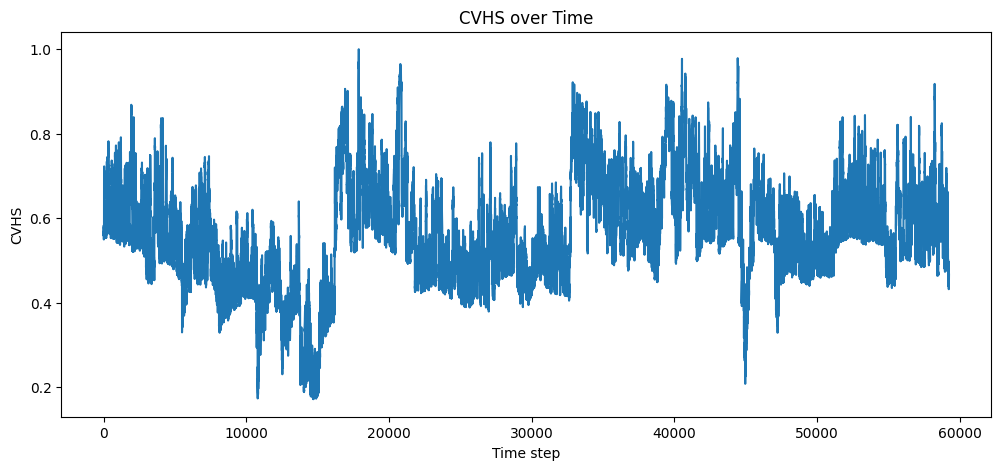

In [4]:
# 3. Data visualization
plt.figure(figsize=(12,5))
plt.plot(df['cvhs'])
plt.title('CVHS over Time')
plt.xlabel('Time step')
plt.ylabel('CVHS')
plt.show()

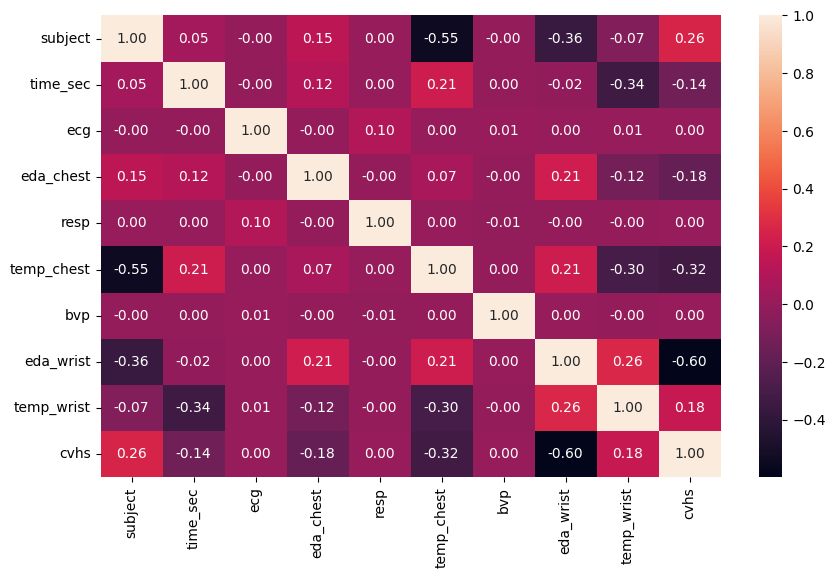

In [5]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

In [6]:
df.ffill(inplace=True)

In [7]:

features = ['subject','ecg','eda_chest','resp','temp_chest','bvp','eda_wrist','temp_wrist']
target = 'cvhs'

In [8]:
# Standardize
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [9]:
# 5. Windowing: 1 min windows with 50% overlap
# -------------------------
window_size = 60  # 60 sec
step_size = 30    # 50% overlap

X_windows = []
y_windows = []

for i in range(0, len(df) - window_size + 1, step_size):
    window = df[features].iloc[i:i+window_size].values
    target_window = df[target].iloc[i:i+window_size].mean()  # average cvhs
    X_windows.append(window)
    y_windows.append(target_window)

X_windows = np.array(X_windows)
y_windows = np.array(y_windows)

print("X shape:", X_windows.shape)
print("y shape:", y_windows.shape)

X shape: (1973, 60, 8)
y shape: (1973,)


In [10]:
# 6. Train/test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.2, random_state=42)


In [11]:
# -------------------------
# 7. Model: 1D CNN + LSTM
# -------------------------
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.2),
    Conv1D(32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    LSTM(50, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 58, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 58, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 56, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,811 (96.92 KB)

 Trainable params: 24,619 (96.17 KB)

 Non-trainable params: 192 (768.00 B)

In [12]:

# 8. Training
# -------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stop])

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - loss: 0.1402 - mae: 0.2840 - val_loss: 0.0700 - val_mae: 0.2457
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0165 - mae: 0.0977 - val_loss: 0.0291 - val_mae: 0.1442
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0101 - mae: 0.0802 - val_loss: 0.0097 - val_mae: 0.0737
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0083 - mae: 0.0716 - val_loss: 0.0062 - val_mae: 0.0608
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0075 - mae: 0.0687 - val_loss: 0.0056 - val_mae: 0.0580
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0069 - mae: 0.0646 - val_loss: 0.0056 - val_mae: 0.0594
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0070 - mae: 0.0649 - val_loss: 0.0064 - val_mae: 0.0644
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0067 - mae: 0.0631 - val_loss: 0.0052 - val_mae: 0.0560
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0

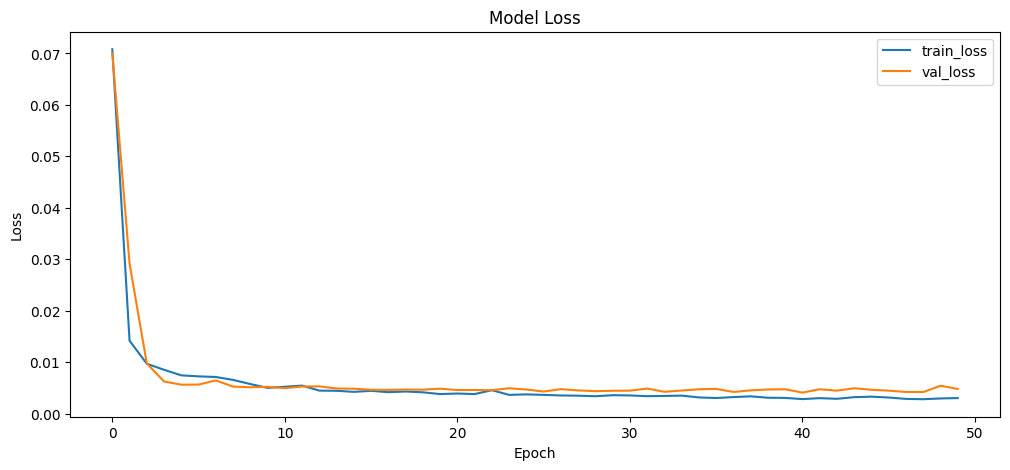

In [13]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test MAE:", test_mae)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - mae: 0.0459
Test MAE: 0.04692121967673302


In [16]:
model.save("cvhs.keras")
print("Model saved successfully!")

Model saved successfully!


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


y_pred = model.predict(X_test).flatten()

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Test Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test Metrics:
MSE: 0.0035
RMSE: 0.0591
MAE: 0.0469
R² Score: 0.7310
MAPE: 8.63%


The model performs very well with low error rates (MSE: 0.0035, MAE: 0.0469) and high explanatory power (R²: 0.731), indicating strong predictive accuracy for CVHS values.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


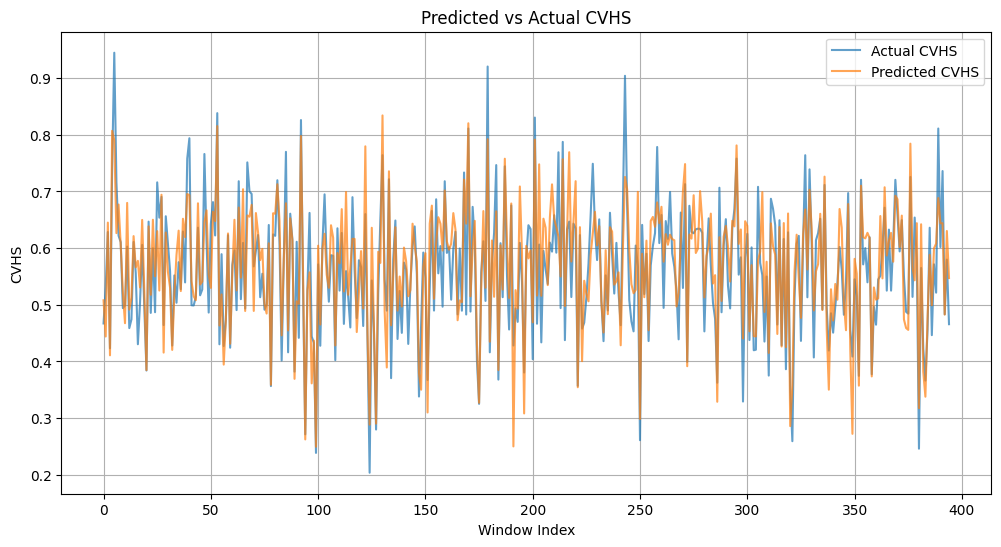

In [18]:
# Predict on test set
y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(12,6))
plt.plot(y_test, label="Actual CVHS", alpha=0.7)
plt.plot(y_pred, label="Predicted CVHS", alpha=0.7)
plt.title("Predicted vs Actual CVHS")
plt.xlabel("Window Index")
plt.ylabel("CVHS")
plt.legend()
plt.grid(True)
plt.show()


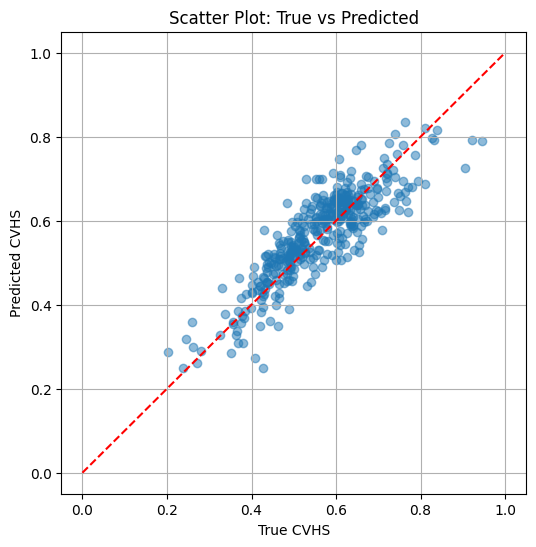

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0,1],[0,1],'r--')
plt.xlabel("True CVHS")
plt.ylabel("Predicted CVHS")
plt.title("Scatter Plot: True vs Predicted")
plt.grid(True)
plt.show()


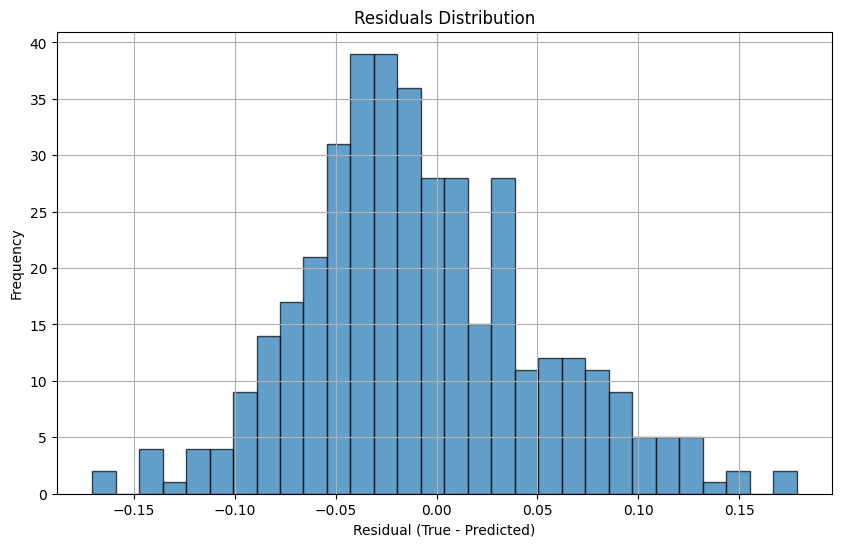

In [20]:
residuals = y_test - y_pred
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title("Residuals Distribution")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


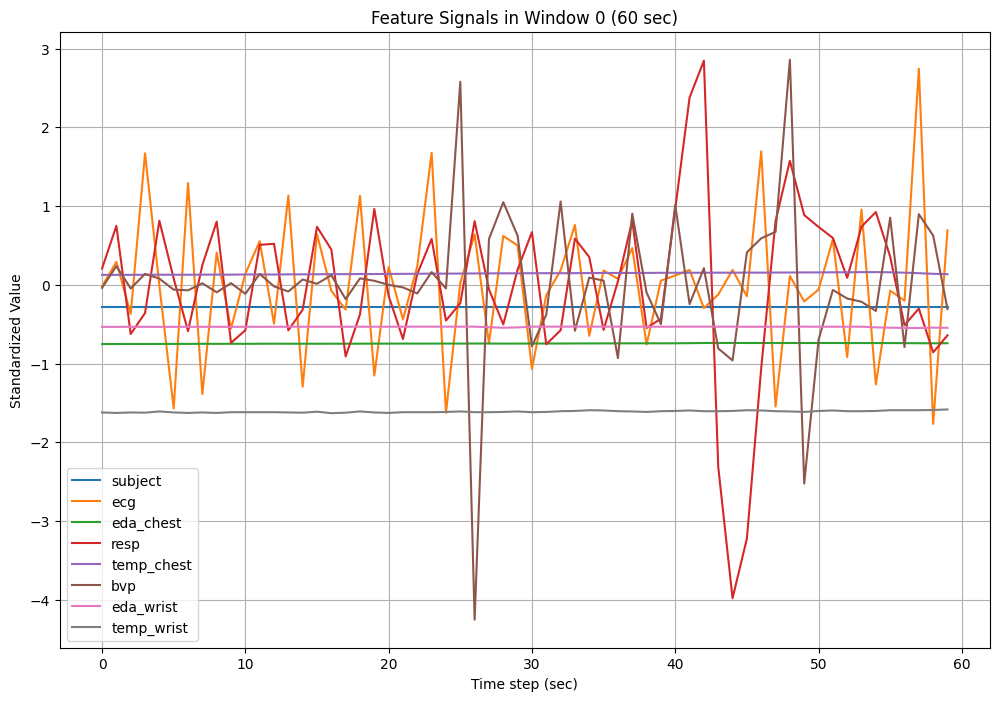

In [21]:
window_idx = 0
window_data = X_test[window_idx]

plt.figure(figsize=(12,8))
for i, feature in enumerate(features):
    plt.plot(window_data[:, i], label=feature)
plt.title(f"Feature Signals in Window {window_idx} (60 sec)")
plt.xlabel("Time step (sec)")
plt.ylabel("Standardized Value")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np

# Predict CVHS for all test windows
y_pred = model.predict(X_test).flatten()

def interactive_window_dashboard(window_idx=0):
    window_data = X_test[window_idx]
    actual_cvhs = y_test[window_idx]
    predicted_cvhs = y_pred[window_idx]

    plt.figure(figsize=(15,8))


    for i, feature in enumerate(features):
        plt.plot(window_data[:, i], label=feature)

    plt.title(f"Window {window_idx} (60 sec)")
    plt.xlabel("Time step (sec)")
    plt.ylabel("Standardized Feature Value")
    plt.legend()
    plt.grid(True)


    plt.text(0, window_data.max() + 0.2, f"Actual CVHS: {actual_cvhs:.3f}", fontsize=12, color='green')
    plt.text(0, window_data.max() + 0.4, f"Predicted CVHS: {predicted_cvhs:.3f}", fontsize=12, color='red')

    plt.show()

# Interactive slider
interact(interactive_window_dashboard, window_idx=(0, len(X_test)-1, 1))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


interactive(children=(IntSlider(value=0, description='window_idx', max=394), Output()), _dom_classes=('widget-…

<function __main__.interactive_window_dashboard(window_idx=0)>